## Singular Structure Eigenfunction Plots

The purpose of this code is to create a visualisation of the eigenfunctions on the 5-vertex quantum graph.
Graph specifications are as follows:
\begin{align}
    l_{13} = b, &\quad l_{31} = 1-b, \quad \theta_{13} = \theta_{31} = \theta_2, \\
    l_{23} = a, &\quad l_{32} = 1-a, \quad \theta_{23} = \theta_{32} = \theta_1.
\end{align}
Implicit functions of $\omega$ are defined as:
\begin{align}
    s_a = \sin(\omega a), &\quad s_b = \sin(\omega b), 
    &\quad c_a = \cos(\omega a), &\quad c_b = \cos(\omega b), \\
    \tilde{s}_a = \sin(\omega (1-a)), &\quad \tilde{s}_b = \sin(\omega (1-b)), 
    &\quad \tilde{c}_a = \cos(\omega (1-a)), &\quad \tilde{c}_b = \cos(\omega (1-b)).
\end{align}

We know that the eigenvalues (and quasi-momentum) which provide the $M$-matrix with a zero eigenvalue are related by
\begin{align}
    \cos(\omega) - \frac{\alpha\omega}{4}\sin(\omega) = \cos\left( \frac{\theta_1-\theta_2}{2} \right) \cos\left( \frac{\theta_1+\theta_2}{2} \right). \qquad (*)
\end{align}

As such, our plan is as follows:
- Find $(\omega, \theta)$ pairs that provide $M_{\theta}$ with a zero eigenvalue.
- Compute the eigenvector $w$ corresponding to this pair. $w$ contains the Dirichlet values of the eigenfunction.
- Compute the eigenfunctions on the edges.
- Plot the resulting functions in a graphically pleasing way.

In [1]:
import numpy as np
from numpy import sin, cos, exp

from scipy.optimize import fsolve
from scipy.linalg import eigh, solve

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

%matplotlib inline

from mpl_toolkits.mplot3d import axes3d, proj3d

import time
import pylab

#### `Psi(omega, alpha)`

Computes the value of the left-hand-side (LHS) of the equation $(*)$, for the given value of $\omega=$ `omega` and $\alpha=$ `alpha`.

`omega` may be passed in as a vector, in which case `Psi` will compute the value of the LHS of $(*)$ for each value in `omega`, returning an array of the same shape. 

In [2]:
def Psi(omega, alpha):
    '''
    Computes the LHS of equation (*), for vector omega and scalar alpha
    INPUTS:
        omega: (n,) float numpy array; values of omega to compute LHS of (*) at
        alpha: float; value of alpha to use
    OUTPUTS:
        LHS: (n,) numpy array; values of the LHS of (*) at the values of omega that were given
    '''
    
    LHS = np.cos(omega) - (alpha * omega * np.sin(omega))/4.0
    return LHS

#### `Phi(theta)`

Computes the value of the function $\Phi$ defined above, equivalently half the value of the right-hand-side (RHS) of the equation $(*)$, at the value $\theta$ = `theta`.

`theta` can be of shape `(n,2)`, in which case the function returns a vector of shape `(n,)` with the values of $\Phi$, using each row of `theta` as a pair $\theta_1, \theta_2$.

In [3]:
def Phi(theta):
    '''
    Computes the RHS of equation (*) for theta1, theta2 pairs stored row-wise (theta of shape (n,2))
    INPUTS:
        theta: (n,2) numpy array; quasimomentum pairs stored row-wise
    OUTPUTS:
        RHS: (n,) numpy array; RHS of equation (*) for the theta pairs passed
    '''
    
    if theta.ndim>1:
        RHS = np.sum(np.cos(theta), axis=1) / 2.0
    else:
        # if theta is of shape (2,), we can't use the np.sum function.
        # we can handle this case here, however if we know that a shape (2,) is being passed in, we can also handle
        # it by passing in np.array([theta]) instead.
        if theta.ndim==1:
            RHS = np.sum(np.cos(theta)) / 2.0
        else:
            raise AxisError('theta must be of shape (n,2) or shape (2,), got', theta.shape)
    return RHS    

#### `MMat(omega, theta, a b)`

Computes the $M$-matrix as below, where `omega`$=\omega$, and `theta`$=\theta$.
\begin{align}
    M_{\theta}(\omega) = 
	\begin{pmatrix}
		-\omega s_a \tilde{s}_a (s_b \tilde{c}_b + c_b \tilde{s}_b) &
		0 &
		\begin{split}
			&\omega s_a \tilde{s}_a (e^{i\theta_2\tilde{b}}s_b + e^{-i\theta_2 b}\tilde{s}_b)
		\end{split} \\
		0 &
		-\omega s_b \tilde{s}_b (s_a \tilde{c}_a + c_a \tilde{s}_a) &
		\begin{split}
			&\omega s_b \tilde{s}_b (e^{i\theta_1\tilde{a}}s_a + e^{-i\theta_1 a}\tilde{s}_a)
		\end{split} \\
		\omega s_a \tilde{s}_a (e^{-i\theta_2\tilde{b})}s_b + e^{i\theta_2 b}\tilde{s}_b) &
		\omega s_b \tilde{s}_b (e^{-i\theta_1\tilde{a}}s_a + e^{i\theta_1 a}\tilde{s}_a) &
		\begin{split}
			&-\omega ( s_a s_b \tilde{s}_a \tilde{c}_b 
			+ s_a s_b \tilde{c}_a \tilde{s}_b \\ 
			& + s_a c_b \tilde{s}_a \tilde{s}_b
			+ c_a s_b \tilde{s}_a \tilde{s}_b \\
			& - \omega\alpha_3 s_a s_b \tilde{s}_a \tilde{s}_b )
		\end{split}
	\end{pmatrix}.
\end{align}

This is the explicit form for the M-matrix for this quantum graph problem, as determined by Proposition 4.1 / Corollary 4.2, Paper_Scalar2020.

In [4]:
def MMat(omega, theta, alpha, a, b):
    '''
    Computes the M-matrix at the value omega, given the quasi-momentum theta
    INPUTS:
        omega: float; value of omega to compute M-matrix at
        theta: (2,) numpy array; quasimomentum value
        alpha: float; value of coupling constant alpha at vertex v_3
    OUTPUTS:
        M: (3,3) numpy array; M-matrix evaluated at the given values
    '''
    
    M = np.zeros((3,3), dtype=complex)
    
    at = 1.0 - a; bt = 1.0 - b
    sa = sin(a*omega); sb = sin(b*omega)
    sat = sin(at*omega); sbt = sin(bt*omega)
    ca = cos(a*omega); cb = cos(b*omega)
    cat = cos(at*omega); cbt = cos(bt*omega)
    
    M[0,0] = -omega*sa*sat*(sb*cbt + cb*sbt)
    M[0,2] = omega*sa*sat*( exp(1.j*theta[1]*bt)*sb + exp(-1.j*theta[1]*b)*sbt )
    M[1,1] = -omega*sb*sbt*(sa*cat + ca*sat)
    M[1,2] = omega*sb*sbt*( exp(1.j*theta[0]*at)*sa + exp(-1.j*theta[0]*a)*sat )
    M[2,0] = omega*sa*sat*( exp(-1.j*theta[1]*bt)*sb + exp(1.j*theta[1]*b)*sbt )
    M[2,1] = omega*sb*sbt*( exp(-1.j*theta[0]*at)*sa + exp(1.j*theta[0]*a)*sat )
    M[2,2] = -omega*( sa*sb*sat*cbt + sa*sb*cat*sbt + sa*cb*sat*sbt + ca*sb*sat*sbt - omega*alpha*sa*sb*sat*sbt )
    
    return M

#### `Edgefunction(l, omega, qm, uj, uk, tol)`

Creates a function handle for the function $u_{jk}$, given the Dirichlet data for this function, the length $l_{jk}$ of $I_{jk}$, and present value of $\omega$ and $\theta$.

To compute the eigenfunctions, we know that the solution $u_{jk}$ on each edge has the form
\begin{align}
    u_{jk}(y) &= e^{-i\theta_{jk}y} ( C^+ e^{i\omega y} + C^- e^{-i\omega y} ),
\end{align}
and given that
\begin{align}
    u_{jk}(v_j) = u_{jk}(0) = u_j, \qquad u_{jk}(v_k) = u_{jk}(l_{jk}) = u_k,
\end{align}
we can find the constants via solution of
\begin{align}
    \begin{pmatrix}
        1 & 1 \\ e^{i\omega l_{jk}} & e^{-i\omega l_{jk}}
    \end{pmatrix}
    \begin{pmatrix} C^+ \\ C^- \end{pmatrix}
    &=
    \begin{pmatrix} u_j \\ e^{i\theta_{jk}l_{jk}} u_k \end{pmatrix}.
\end{align}
Note that if $sin(l_{jk}\omega) = 0$ then this system is not uniquely solvable! 
Otherwise, solution for these constants is given by
\begin{align}
    C^+ &= \frac{ u_k e^{i\theta_{jk}l_{jk}} - u_je^{-i\omega l_{jk}} }{ 2i\sin(\omega l_{jk}) }, \\
    C^- &= u_j - C^+.
\end{align}

In [5]:
def EdgeFunction(l, omega, qm, uj, uk, tol=1e-8):
    '''
    Construct the function u_{jk} on the edge I_{jk}, given the length of the edge 
    and the Dirichlet values of u_{jk} at the ends of the edge.
    INPUTS:
        l: float; length of the edge I_{jk}
        omega: complex float; value of omega
        qm: float; value of the quasimomentum \theta_{jk} on this edge
        uj: complex float; value of u_{jk}(0) = u_{jk}(v_j)
        uk: complex float; value of u_{jk}(l) = u_{jk}(v_k)
        tol: (optional) float - default 1e-8; tolerance to check determinant of linear system is zero to
    OUTPUTS:
        u: lambda function (x); the function u_{jk} evaluated at x\in I_{jk}
    '''
    
    A = np.zeros((2,2), dtype=complex)
    A[0,0] = 1.0 + 0.j
    A[0,1] = 1.0 + 0.j
    A[1,0] = exp( 1.j*omega*l )
    A[1,1] = exp( -1.j*omega*l )
    
    b = np.zeros((2,), dtype=complex)
    b[0] = uj
    b[1] = uk * exp( 1.j*qm*l )
    
    # NB check that determinant is non-zero!
    if np.abs( sin(omega*l) ) <= tol:
        raise ValueError('Non-unique solution to linear system!')
    else:
        # we are fine, solve the linear system for the constants
        c = solve(A, b)
    # now we can reconstruct the function u_{jk}
    def u(x):
        '''
        Edge function u_{jk}, constructed from EdgeFunction
        INPUTS:
            x: (n,) numpy float array; values in [0,l_{jk}] to evaluate edge function at
        OUTPUTS:
            ux: (n,) numpy complex float array; values of u_{jk}(x) evaluated element-wise
        '''
        
        ux = exp( -1.j*qm*x ) * ( c[0]*exp( 1.j*omega*x ) + c[1]*exp( -1.j*omega*x) )
        
        return ux
    # return the function on the edge
    return u

#### `EdgefunctionDT(l, omega, qm, uj, uk, tol)`

Creates a function handle for the function $\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + i\theta_{jk}\right)u_{jk}$, given the Dirichlet data for this function, the length $l_{jk}$ of $I_{jk}$, and present value of $\omega$ and $\theta$.
**NOTE:** Signed derivative is NOT returned at the endpoints! Manual multiplication by exterior normal is required.

To compute the eigenfunctions, we know that the solution $u_{jk}$ on each edge has the form
\begin{align}
    u_{jk}(y) &= e^{-i\theta_{jk}y} ( C^+ e^{i\omega y} + C^- e^{-i\omega y} ),
\end{align}
and given that
\begin{align}
    u_{jk}(v_j) = u_{jk}(0) = u_j, \qquad u_{jk}(v_k) = u_{jk}(l_{jk}) = u_k,
\end{align}
we can find the constants via solution of
\begin{align}
    \begin{pmatrix}
        1 & 1 \\ e^{i\omega l_{jk}} & e^{-i\omega l_{jk}}
    \end{pmatrix}
    \begin{pmatrix} C^+ \\ C^- \end{pmatrix}
    &=
    \begin{pmatrix} u_j \\ e^{i\theta_{jk}l_{jk}} u_k \end{pmatrix}.
\end{align}
Note that if $sin(l_{jk}\omega) = 0$ then this system is not uniquely solvable! 
Otherwise, solution for these constants is given by
\begin{align}
    C^+ &= \frac{ u_k e^{i\theta_{jk}l_{jk}} - u_je^{-i\omega l_{jk}} }{ 2i\sin(\omega l_{jk}) }, \\
    C^- &= u_j - C^+.
\end{align}

Then, upon differentiating we have that
\begin{align*}
    \left(\dfrac{\mathrm{d}}{\mathrm{d}y} + i\theta_{jk}\right)u_{jk} &= i\omega e^{-i\theta_{jk}y} ( C^+ e^{i\omega y} - C^- e^{-i\omega y} )
\end{align*}

In [6]:
def EdgeFunctionDT(l, omega, qm, uj, uk, tol=1e-8):
    '''
    Construct the function (d/dy + i\qm)u_{jk} on the edge I_{jk}, given the length of the edge 
    and the Dirichlet values of u_{jk} at the ends of the edge.
    INPUTS:
        l: float; length of the edge I_{jk}
        omega: complex float; value of omega
        qm: float; value of the quasimomentum \theta_{jk} on this edge
        uj: complex float; value of u_{jk}(0) = u_{jk}(v_j)
        uk: complex float; value of u_{jk}(l) = u_{jk}(v_k)
        tol: (optional) float - default 1e-8; tolerance to check determinant of linear system is zero to
    OUTPUTS:
        du: lambda function (x); the function (d/dy + i\qm)u_{jk} evaluated at x\in I_{jk}
    '''
    
    A = np.zeros((2,2), dtype=complex)
    A[0,0] = 1.0 + 0.j
    A[0,1] = 1.0 + 0.j
    A[1,0] = exp( 1.j*omega*l )
    A[1,1] = exp( -1.j*omega*l )
    
    b = np.zeros((2,), dtype=complex)
    b[0] = uj
    b[1] = uk * exp( 1.j*qm*l )
    
    # NB check that determinant is non-zero!
    if np.abs( sin(omega*l) ) <= tol:
        raise ValueError('Non-unique solution to linear system!')
    else:
        # we are fine, solve the linear system for the constants
        c = solve(A, b)
    # now we can reconstruct the function u_{jk}
    def du(x):
        '''
        Edge function u_{jk}, constructed from EdgeFunction
        INPUTS:
            x: (n,) numpy float array; values in [0,l_{jk}] to evaluate edge function at
        OUTPUTS:
            ux: (n,) numpy complex float array; values of u_{jk}(x) evaluated element-wise
        '''
        
        dux = 1.j * omega * exp( -1.j*qm*x ) * ( c[0]*exp( 1.j*omega*x ) - c[1]*exp( -1.j*omega*x) )
        
        return dux
    # return the function on the edge
    return du

#### `MakeProjectionPlot(theta, searchRange, alpha=1.0, a=1./np.sqrt(2.), b=1./np.sqrt(3.), tol=1e-8)`

Given the geometric parameters for the graph (the coupling constant $\alpha$, and the lengths $a$, $b$) and the value of the quasi-momentum $\theta$, we can solve $(*)$ to determine the eigenfunction $u$ correspnding to the pair $(\omega, \theta)$.

The input `searchRange` is designed to speed up the process of finding a good "inital guess" for solving $(*)$.
`MakeProjectionPlot` will evaluate $(*)$ at all points in `searchRange`, and use the value closest to equality as the starting guess for the numerical solve.
For good results, ensure that `searchRange` encompasses at least one full spectral band - these have the form $I_n=[(n-1)\pi, n\pi]$ for $n\in\mathbb{N}$, and ensure that the solve will determine (at least one) eigenvalue $\omega$ for each $\theta$.

We return the `fig` and `ax` objects for the plot.
This plot is 3D, with the graph plotted in the $xy$ plane and the various edge functions $u_{jk}$ plotted _above_ the edge they correspond to, in the $z$-axis.
This allows us to see continuity of the eigenfunctions at the vertices of the graph, and (knowing that the graph represents a unit cell) the periodicity of the solution too.

In [7]:
def MakeProjectionPlot(theta, searchRange, alpha=1.0, a=1./np.sqrt(2.), b=1./np.sqrt(3.), tol=1e-8):
    '''
    Given the geometric parameters of the graph, along with the central coupling constant and
    quasi-momentum value, produce a plot of the eigenfunction corresponding to the eigenvalue pair
    (omega, theta).
    INPUTS:
        theta: (2,) float array; value of the quasi-momentum
        searchRange: (n,) float array; range in which to search for the eigenvalue omega.
            Typically, this should encompass a whole number of spectral bands, EG be equal to [n\pi, (n+1)\pi]
        alpha: (optional) float - default 1.0; value of the coupling constant at v_3
        a, b: (optional) float - default 1/sqrt(2), 1/sqrt(3); the lengths of the broken edges where artifical
            vertices were introduced. a,b should be irrationally related.
        tol: (optional) float - default 1e-8; tolerance to which we accept numerical solutions as correct
    OUTPUTS:
        fig, ax: matplotlib figure handles; plot window contains a 3D rendition of the eigenfunction with the
            graph underneath.
    '''
    # setup geometric parameters
    l13 = b; l31 = 1. - b
    l23 = a; l32 = 1. - a
    qm13 = theta[1]; qm31 = theta[1]
    qm23 = theta[0]; qm32 = theta[0]

    # function handle to solve the DR (*)
    DRHandle = lambda w: (Psi(w, alpha) - Phi(theta))
    # find a good initial guess by evaluating DRHandle across the search range
    DRVals = DRHandle(searchRange)
    omega0 = searchRange[np.argmin(np.abs(DRVals))]

    # find eigenvalue corresponding to theta0
    omega = fsolve(DRHandle, omega0)
    # reality check
    if np.abs(DRHandle(omega))>tol:
        raise ValueError('Root does not fit specified tolerance.')
    else:
        print('Found root omega=%.5f' % omega)
        
    # otherwise, (omega, theta) is a pair at which M has a zero-eigenvalue
    # compute the M-matrix at omega, theta
    M = MMat(omega, theta, alpha, a, b)
    # compute eigenvalues and eigenvectors of M
    wVals, wVecs = eigh(M)
    # determine the eigenvector that corresponds to the zero eigenvalue
    eValInd = np.argmin(np.abs(wVals))
    eVal = wVals[eValInd]; eVec = wVecs[:,eValInd]
    # reality checks
    if np.max( np.abs( np.matmul(M, eVec) ) ) >= tol:
        raise ValueError('M * eVec =\= 0')
    elif np.abs(eVal) >= tol:
        raise ValueError('Found non-zero eigenvalue %.5f' % eVal)
    else:
        print('Found zero eigenvalue: %.3e' % eVal)
        print('Corresponding eigenvector:', eVec)

    # so now we have the Dirichlet data for our eigenfunction, stored in eVec.
    # we can reconstruct the edge-functions now
    u13 = EdgeFunction(l13, omega, qm13, eVec[0], eVec[2], tol=1e-8)
    u31 = EdgeFunction(l31, omega, qm31, eVec[2], eVec[0], tol=1e-8)
    u23 = EdgeFunction(l23, omega, qm23, eVec[1], eVec[2], tol=1e-8)
    u32 = EdgeFunction(l32, omega, qm32, eVec[2], eVec[1], tol=1e-8)

    # setup the intervals corresponding to the edges
    I13 = np.linspace(0,l13,1000); I31 = np.linspace(0,l31,1000)
    I23 = np.linspace(0,l23,1000); I32 = np.linspace(0,l32,1000)

    # prepare the figure window
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_title(r'Real part of edge functions')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_zlabel(r'$u_{jk}(x_1,x_2)$')
    ax.dist = 11

    # plot the edge functions
    x23 = I23; x32 = l23 + I32
    y23 = l13 * np.ones_like(x23); y32 = l13 * np.ones_like(x32)
    z23 = np.real( u23(I23) ); z32 = np.real( u32(I32) )
    ax.plot(x23, y23, z23, 'red', label=r'$u_{23}$')
    ax.plot(x32, y32, z32, 'orange', label=r'$u_{32}$')


    y13 = I13; y31 = l13 + I31
    x13 = l23 * np.ones_like(y13); x31 = l23 * np.ones_like(y31)
    z13 = np.real( u13(I13) ); z31 = np.real( u31(I31) )
    ax.plot(x13, y13, z13, 'blue', label=r'$u_{13}$')
    ax.plot(x31, y31, z31, 'cyan', label=r'$u_{31}$')

    # find the minimum height to plot the graph edges on
    zMin = np.min( (z31,z31,z23,z32) )
    ax.plot(x13, y13, zMin, 'grey') #label='$I_{31}$'
    ax.plot(x31, y31, zMin, 'grey') #label='$I_{31}$'
    ax.plot(x23, y23, zMin, 'grey') #label='$I_{23}$'
    ax.plot(x32, y32, zMin, 'grey') #label='$I_{32}$'

    # plot a dashed line upwards from v3
    zMax = np.max( (z31,z31,z23,z32) )
    ax.plot(l23*np.ones((250,)), l13*np.ones((250,)), np.linspace(zMin, zMax, 250), 'grey', linestyle='dashed')

    # annotate the position of v3
    v3x2, v3y2, _ = proj3d.proj_transform(l23,l13,zMin, ax.get_proj())
    pylab.annotate(
        r'$v_3$', 
        xy = (v3x2, v3y2), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'left', va = 'top',
        bbox = dict(boxstyle = 'circle,pad=0.25', fc = 'grey', alpha = 0.21),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    # annotate edges
    i13x, i13y, _ = proj3d.proj_transform(l23, l13/4., zMin, ax.get_proj())
    pylab.annotate(r'$I_{13}$', xy = (i13x, i13y), xytext = (10, -10),
                   textcoords = 'offset points', ha = 'left', va = 'bottom')
    i31x, i31y, _ = proj3d.proj_transform(l23, l13 + l31*1./1., zMin, ax.get_proj())
    pylab.annotate(r'$I_{31}$', xy = (i31x, i31y), xytext = (5, -10),
                   textcoords = 'offset points', ha = 'left', va = 'bottom')
    i23x, i23y, _ = proj3d.proj_transform(l23*1./16., l13, zMin, ax.get_proj())
    pylab.annotate(r'$I_{23}$', xy = (i23x, i23y), xytext = (10, -10),
                   textcoords = 'offset points', ha = 'left', va = 'top')
    i32x, i32y, _ = proj3d.proj_transform(l23 + l32*2./4., l13, zMin, ax.get_proj())
    pylab.annotate(r'$I_{32}$', xy = (i32x, i32y), xytext = (0, -5),
                   textcoords = 'offset points', ha = 'left', va = 'top')

    # change background colours
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # remove gridmesh
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    # provide legend
    ax.legend(loc='center left')

    return fig, ax

### Making Projection Plots

We now need to create the 3D plot, given that we have the functions on each edge and their function handles.

The vertex $v_3$ is at position $(a, b) = (l_{13}, l_{23})$ in the $x-y$ plane.

Found root omega=0.63936
Found zero eigenvalue: 1.214e-17
Corresponding eigenvector: [0.57139338+0.j         0.57380667+0.0007931j  0.58673202-0.00064655j]


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


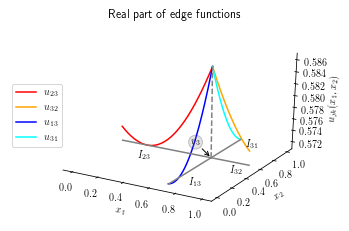

In [8]:
# Graph parameters
alpha = 1.0
a = 1./np.sqrt(2.); b = 1./np.sqrt(3.)
# Range in which to search for eigenvalue (typically a band of the form [(n-1)pi,pi])
searchRange = np.linspace(0, np.pi, 1000)
theta = np.array([np.pi/4., np.pi/4.])

funcFig, funcAx = MakeProjectionPlot(theta, searchRange, alpha=alpha, a=a, b=b)

if 1==0:
    saveStr = time.strftime('%d-%m-%y_%H-%M') + '3D-EdgePlot.pdf'
    funcFig.savefig(saveStr, bbox_inches='tight')
funcFig.show()

#### Checking The Individual Function Plots Themselves...

Plots for some eyeball-norm checks on function behaviour, etc.

In [15]:
# Some reality checks for our functions - should be able to piece them together right...?

alpha = 1.0
a = 1./np.sqrt(2.); b = 1./np.sqrt(3.)

l13 = b; l31 = 1. - b
l23 = a; l32 = 1. - a
qm13 = theta[1]; qm31 = theta[1]
qm23 = theta[0]; qm32 = theta[0]

I13 = np.linspace(0,l13,1000)
I31 = np.linspace(0,l31,1000)
I23 = np.linspace(0,l23,1000)
I32 = np.linspace(0,l32,1000)

tol=1e-8

# function handle to solve the DR (*)
DRHandle = lambda w: (Psi(w, alpha) - Phi(theta))
# find a good initial guess by evaluating DRHandle across the search range
DRVals = DRHandle(searchRange)
omega0 = searchRange[np.argmin(np.abs(DRVals))]

# find eigenvalue corresponding to theta0
omega = fsolve(DRHandle, omega0)
# reality check
if np.abs(DRHandle(omega))>tol:
    raise ValueError('Root does not fit specified tolerance.')

# otherwise, (omega, theta) is a pair at which M has a zero-eigenvalue
# compute the M-matrix at omega, theta
M = MMat(omega, theta, alpha, a, b)
# compute eigenvalues and eigenvectors of M
wVals, wVecs = eigh(M)
# determine the eigenvector that corresponds to the zero eigenvalue
eValInd = np.argmin(np.abs(wVals))
eVal = wVals[eValInd]; eVec = wVecs[:,eValInd]
# reality checks
if np.max( np.abs( np.matmul(M, eVec) ) ) >= tol:
    raise ValueError('M * eVec =\= 0')
elif np.abs(eVal) >= tol:
    raise ValueError('Found non-zero eigenvalue %.5f' % eVal)

# so now we have the Dirichlet data for our eigenfunction, stored in eVec.
# we can reconstruct the edge-functions now
u13 = EdgeFunction(l13, omega, qm13, eVec[0], eVec[2], tol=1e-8)
u31 = EdgeFunction(l31, omega, qm31, eVec[2], eVec[0], tol=1e-8)
u23 = EdgeFunction(l23, omega, qm23, eVec[1], eVec[2], tol=1e-8)
u32 = EdgeFunction(l32, omega, qm32, eVec[2], eVec[1], tol=1e-8)

# check expectation vs reality...

# Can manually check the boundary conditions at each of the vertices now then...
# Continuity first
# v_1
if np.abs( u13(0) - u31(l31) ) >= tol:
    print('Continuity broken at v_1; %.5f (u_13) vs %.5f (u_31)' % (u13(0), u31(l31)))
else:
    print('Continuity at v_1 confirmed.')
# v_2
if np.abs( u23(0) - u32(l32) ) >= tol:
    print('Continuity broken at v_2; %.5f (u_23) vs %.5f (u_32)' % (u23(0), u32(l32)))
else:
    print('Continuity at v_2 confirmed.')
    # v_3
refValV3 = u31(0)
if np.abs( u13(l13) - refValV3 ) >= tol:
    print('Continuity broken at v_3; %.5f (u_13) vs %.5f (refVal)' % (u13(l13), refVal))
elif np.abs( u31(0) - refValV3 ) >= tol:
    print('Continuity broken at v_3; %.5f (u_31) vs %.5f (refVal)' % (u31(0), refVal))
elif np.abs( u23(l23) - refValV3 ) >= tol:
    print('Continuity broken at v_3; %.5f (u_23) vs %.5f (refVal)' % (u23(l23), refVal))
elif np.abs( u32(0) - refValV3 ) >= tol:
    print('Continuity broken at v_3; %.5f (u_32) vs %.5f (refVal)' % (u32(0), refVal))
else:
    print('Continuity at v_3 confirmed.')
    
# Now Kirchoff-like conditions - construct handles for (d/dy + i\qm)u...
du13 = EdgeFunctionDT(l13, omega, qm13, eVec[0], eVec[2], tol=1e-8)
du31 = EdgeFunctionDT(l31, omega, qm31, eVec[2], eVec[0], tol=1e-8)
du23 = EdgeFunctionDT(l23, omega, qm23, eVec[1], eVec[2], tol=1e-8)
du32 = EdgeFunctionDT(l32, omega, qm32, eVec[2], eVec[1], tol=1e-8)
v1Val = 0.; v2Val = 0.; 
v3Val = refValV3 * alpha * omega * omega
# values of the signed-derivative sums
dSumV1 = du31(l31) - du13(0)
dSumV2 = du32(l32) - du23(0)
dSumV3 = du13(l13) + du23(l23) - du31(0) - du32(0)
# compare values...
if np.abs( dSumV1 - v1Val ) >= tol:
    print('NC-Kirchoff broken at v_1; %.5f+%.5fi (sum) vs %.5f+%.5fi (omega2 x alpha x u(v1))' \
          % (np.real(dSumV1), np.imag(dSumV1), np.real(v1Val), np.imag(v1Val)))
if np.abs( dSumV2 - v1Val ) >= tol:
    print('NC-Kirchoff broken at v_2; %.5f+%.5fi (sum) vs %.5f+%.5fi (omega2 x alpha x u(v2))' \
          % (np.real(dSumV2), np.imag(dSumV2), np.real(v2Val), np.imag(v2Val)))
if np.abs( dSumV3 - v1Val ) >= tol:
    print('NC-Kirchoff broken at v_3; %.5f+%.5fi (sum) vs %.5f+%.5fi (omega2 x alpha x u(v3))' \
          % (np.real(dSumV3), np.imag(dSumV3), np.real(v3Val), np.imag(v3Val)))

if 1==0:
    # Plot real parts, check that things match up at the ``dummy" vertices
    fig, ax = plt.subplots(1)
    ax.set_title(r'Real part, $u_{31}$ and $u_{13}$')
    ax.set_ylabel(r'$\Re(u)$')
    ax.set_xlabel(r'$I_{31}$ and $I_{13}$')
    ax.plot( I13 + l31, np.real( u13(I13) ), 'r', label=r'$u_{13}$' )
    ax.plot( I31, np.real( u31(I31) ), 'b', label=r'$u_{31}$' )
    ax.legend()
    fig.show()

    fig, ax = plt.subplots(1)
    ax.set_title(r'Real part, $u_{32}$ and $u_{23}$')
    ax.set_ylabel(r'$\Re(u)$')
    ax.set_xlabel(r'$I_{32}$ and $I_{23}$')
    ax.plot( I23 + l32, np.real( u23(I23) ), 'r', label=r'$u_{23}$' )
    ax.plot( I32, np.real( u32(I32) ), 'b', label=r'$u_{31}$' )
    ax.legend()
    fig.show()

    # Check that imaginary parts of plots also match up
    fig, ax = plt.subplots(1)
    ax.set_title(r'Imag part, $u_{31}$ and $u_{13}$')
    ax.set_ylabel(r'$\Im(u)$')
    ax.set_xlabel(r'$I_{31}$ and $I_{13}$')
    ax.plot( I13 + l31, np.imag( u13(I13) ), 'r', label=r'$u_{13}$' )
    ax.plot( I31, np.imag( u31(I31) ), 'b', label=r'$u_{31}$' )
    ax.legend()
    fig.show()

    fig, ax = plt.subplots(1)
    ax.set_title(r'Imag part, $u_{32}$ and $u_{23}$')
    ax.set_ylabel(r'$\Im(u)$')
    ax.set_xlabel(r'$I_{32}$ and $I_{23}$')
    ax.plot( I23 + l32, np.imag( u23(I23) ), 'r', label=r'$u_{23}$' )
    ax.plot( I32, np.imag( u32(I32) ), 'b', label=r'$u_{32}$' )
    ax.legend()
    fig.show()

Continuity at v_1 confirmed.
Continuity at v_2 confirmed.
Continuity at v_3 confirmed.
NC-Kirchoff broken at v_1; 0.00001+0.00499i (sum) vs 0.00000+0.00000i (omega2 x alpha x u(v1))
NC-Kirchoff broken at v_2; 0.00001+0.01337i (sum) vs 0.00000+0.00000i (omega2 x alpha x u(v2))
NC-Kirchoff broken at v_3; 0.23986+-0.01820i (sum) vs 0.23984+-0.00026i (omega2 x alpha x u(v3))
